# HH network analysis

Some analysis to aid the creation of this HH cell network.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
from collections import Counter

from numpy.fft import fftfreq, fft

from neuron import h
from neuron.units import mV, ms, sec
h.load_file('stdrun.hoc')

sys.path.insert(1, "./utils/")
from Net import Net

## Single network

In [9]:
# set up simulation
print('setting up network')
ex_ratio = .8
num_cells = 500
net = Net(num_cells, ex_ratio)

print('creating network connections')
net.randomly_connect_cells(weight = .2, delay = 2, delay_scaling=False)
net.initial_stimulation(100, 1)

# run simulation
print('running network')
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

print('final spike aggregation')
net.aggregate_all_spikes()

setting up network
creating network connections
running network
final spike aggregation


In [10]:
def color_inhib_vs_excit(cell_cat):
    # help coloring excitatory vs inhibitory stats in our plots
    if cell_cat == 1:
        return 'blue'
    else:
        return 'red'

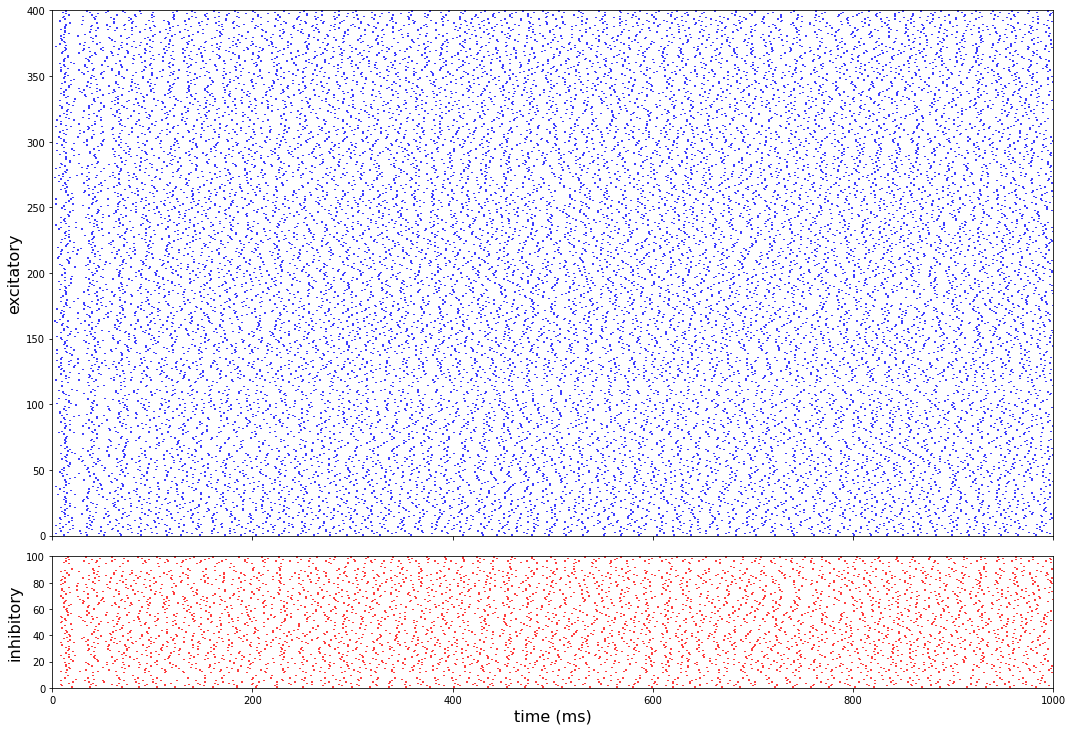

In [11]:
def plot_raster(self, sim_length, ex_ratio):
    fig, axes = plt.subplots(2, 1, figsize = (15,10), sharex = True, gridspec_kw={'height_ratios': [ex_ratio, 1-ex_ratio]})
    
    ex_y = 0
    in_y = 0
    for i, cell in enumerate(self.cells):
        spikes = list(cell.spike_times)
        
        if cell.metadata['cell_cat'] == 1: # excitatory
            axes[0].vlines(spikes, ex_y, ex_y+1, color = color_inhib_vs_excit(cell.metadata['cell_cat']))
            ex_y += 1
        else: # inhibatory
            axes[1].vlines(spikes, in_y, in_y+1, color = color_inhib_vs_excit(cell.metadata['cell_cat']))
            in_y += 1
    axes[0].set_xlim(0, sim_length)
    axes[0].set_ylim(0, ex_y)
    axes[1].set_ylim(0, in_y)
    axes[0].set_ylabel('excitatory', fontsize=16)
    axes[1].set_ylabel('inhibitory', fontsize=16)
    fig.tight_layout()
    plt.xlabel('time (ms)', fontsize=16)

ex_ratio = .8
plot_raster(net, sim_length, ex_ratio)

In [12]:
# plot spike rates
def net_spike_rates(self, sim_length, binsize = 1):  
    ex_hist, bins = np.histogram(self.ex_all_spikes, bins = np.arange(0, sim_length, binsize))
    in_hist, bins = np.histogram(self.in_all_spikes, bins = np.arange(0, sim_length, binsize))
    ex_hist = ex_hist / self.ex_num_cells
    in_hist = in_hist / self.in_num_cells
    bins = np.arange(0, sim_length, binsize)
    return ex_hist, in_hist, bins
    
def plot_net_spike_rates(self, sim_length, binsize = 1):
    ex_hist, in_hist, bins = net_spike_rates(self, sim_length, binsize)
    
    plt.figure(figsize = (15,4))
    plt.plot(np.arange(0, sim_length, binsize)[:-1], ex_hist, color = 'blue', alpha = 0.7)
    plt.plot(np.arange(0, sim_length, binsize)[:-1], in_hist, color = 'red', alpha = 0.7)
    plt.ylabel('ratio of spiking cells', fontsize = 12)
    plt.xlabel('time (ms)', fontsize = 12)
    plt.legend(['excitatory','inhibitory'])
    plt.xlim(0, sim_length)
    plt.grid()
    plt.show()

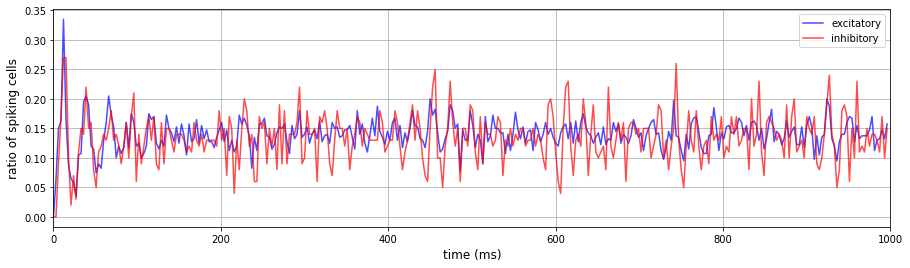

In [13]:
plot_net_spike_rates(net, sim_length, binsize=3)

In [14]:
def net_spike_fft(self, sim_length, dt = 1, min_freq = 0.01):
    hist_ex, bins = np.histogram(self.ex_all_spikes, bins = np.arange(0, sim_length, dt))
    hist_in, bins = np.histogram(self.in_all_spikes, bins = np.arange(0, sim_length, dt))
    # center around 0
    hist_ex = hist_ex / self.ex_num_cells
    hist_in = hist_in / self.in_num_cells
    # calc fft
    yf_ex = fft(hist_ex)
    xf_ex = fftfreq(len(yf_ex), dt) * sec
    yf_in = fft(hist_in)
    xf_in = fftfreq(len(yf_in), dt) * sec
    # isolate freqs of interest
    yf_ex = yf_ex[np.argwhere(xf_ex > min_freq)]
    xf_ex = xf_ex[np.argwhere(xf_ex > min_freq)]
    yf_in = yf_in[np.argwhere(xf_in > min_freq)]
    xf_in = xf_in[np.argwhere(xf_in > min_freq)]
    return xf_ex, yf_ex, xf_in, yf_in

def plot_net_spike_fft(self, sim_length, dt = 1, min_freq = 0.01):
    plt.figure(figsize = (15,4))
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(self, sim_length, dt = 1, min_freq = 0.01)
    plt.fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    
    plt.fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    plt.plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    plt.plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    
    plt.xlim(0, sim_length/2)
    plt.ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    plt.ylabel('power')
    plt.xlabel('freq (Hz)')
    plt.legend(['excitatory','inhibitory'])
    plt.grid()
    plt.show()

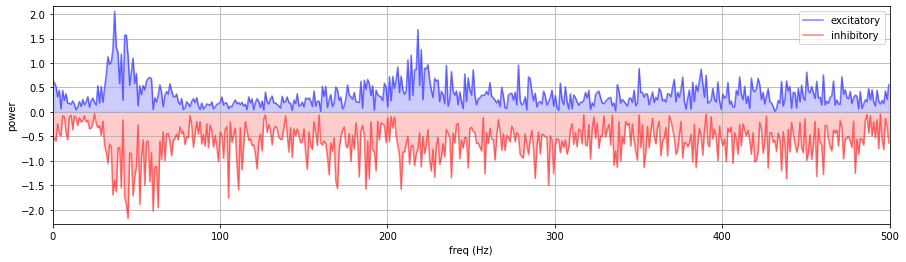

In [15]:
plot_net_spike_fft(net, sim_length)

# Single network key paramters

Calculate the key hyperparameters to use in the NST tree training data.

## NST training data hyperparameters:

### 1) num_histories

    Number of histories to consider: how many histories are needed to 1) represent a sufficient subset of models' states for use in model initiation during training purposes and 2) provide a robust sample size to provide a reasonable NST distribution?

### 2) excitatory stimulus interval

    Poisson paramter for the expected interval of exponentially generated random excitatory stimuli. 

### 3) inhibitory stimulus interval

    Poisson paramter for the expected interval of exponentially generated random inhibitory stimuli.

### 4) stimuli weights

    The weight the stimuli have in the model. Before the weights were different for inhibitory and excitatory but after some consideration this is something that could be made constant.

## NST tree training set observations/hyperparameters we care about:

### 1) ratio of excitatory stimuli to inhibitory stimuli

    This ratio can be replicated in the training data by changing the respective stimulus intervals. 

average ratio between excitatory and inhibitory spike rates: 4.19456301954617


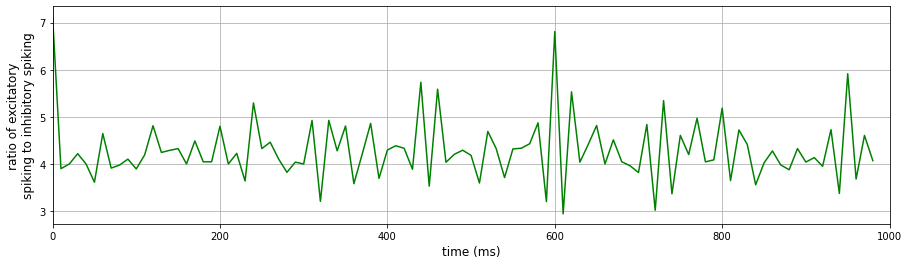

In [27]:
print('average ratio between excitatory and inhibitory spike rates:', len(net.ex_all_spikes) / len(net.in_all_spikes))
binsize = 10

ex_hist, bins = np.histogram(net.ex_all_spikes, bins = np.arange(0, sim_length, binsize))
in_hist, bins = np.histogram(net.in_all_spikes, bins = np.arange(0, sim_length, binsize))

plt.figure(figsize = (15,4))
plt.plot(np.arange(0, sim_length, binsize)[:-1], ex_hist / in_hist, color = 'green')
plt.ylabel('ratio of excitatory\nspiking to inhibitory spiking', fontsize = 12)
plt.xlabel('time (ms)', fontsize = 12)
plt.xlim(0, sim_length)
plt.grid()
plt.show()

### 2) ratio of output spikes to stimuli

    This ratio is important to the quality of the training data (though there are proposed methods to work around this). Ideally we want this ratio to be larger. 

In [33]:
print('expected output spikes to stimuli ratio if each cell spikes with equal chance:')
degrees = [2,3,4,5,6,7]
degrees_p = [0.15, 0.2, 0.3, 0.2, 0.1, 0.05]
print('average cell degree:',sum([degree * degrees_p[i] for i, degree in enumerate(degrees)]))

expected output spikes to stimuli ratio if each cell spikes with equal chance:
average cell degree: 4.05


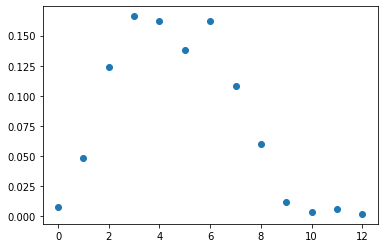

In [63]:
# aggregate the degrees of the cells
cell_degrees = [len(net.targetsources[i]) for i in range(len(net.cells))]
degree_fractions = [0]*(max(cell_degrees)+1)
for cell_degree in cell_degrees:
    degree_fractions[cell_degree] += 1
degree_fractions = [degree / len(net.cells) for degree in degree_fractions]
plt.scatter(range(max(cell_degrees)+1), degree_fractions)
plt.show()

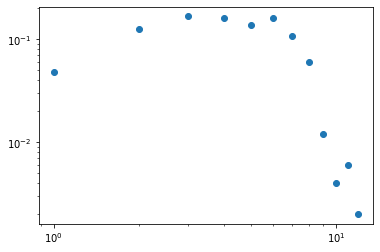

In [66]:
plt.scatter(range(max(cell_degrees)+1), degree_fractions)
plt.yscale('log')
plt.xscale('log')
plt.show()

### 3) probabilities of connections

    This set of hyperparameters, currently coded into the Net.py file, controls the degree to which cells are connected. 
    
    Currently it is:
        degrees = [2,3,4,5,6,7] # degree of each cell (number of forward connections it makes)
        degrees_p = [0.15, 0.2, 0.3, 0.2, 0.1, 0.05] # propensity for each of the respective degrees
    This hyperparameter set has a huge effect on the connectivity of this network.

## Run a series of simulations

### delay spread

Run network with a few different delays and see how synchronized it is.

In [68]:
delays = np.arange(1,7.1,.5)

ex_ratio = .8
n_cells = 200

print('initiating nets')
nets = [Net(n_cells, ex_ratio) for i in range(len(delays))]

print('connecting nets')
for i, delay in enumerate(delays):
    # set up simulation
    nets[i].randomly_connect_cells(weight = .2, delay = delay, delay_scaling=False)
    nets[i].initial_stimulation(100, 1)

print('running simulations simultaneously')
# run simulation
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

[_net.aggregate_all_spikes() for _net in nets]
print('done')

initiating nets
connecting nets
running simulations simultaneously
done


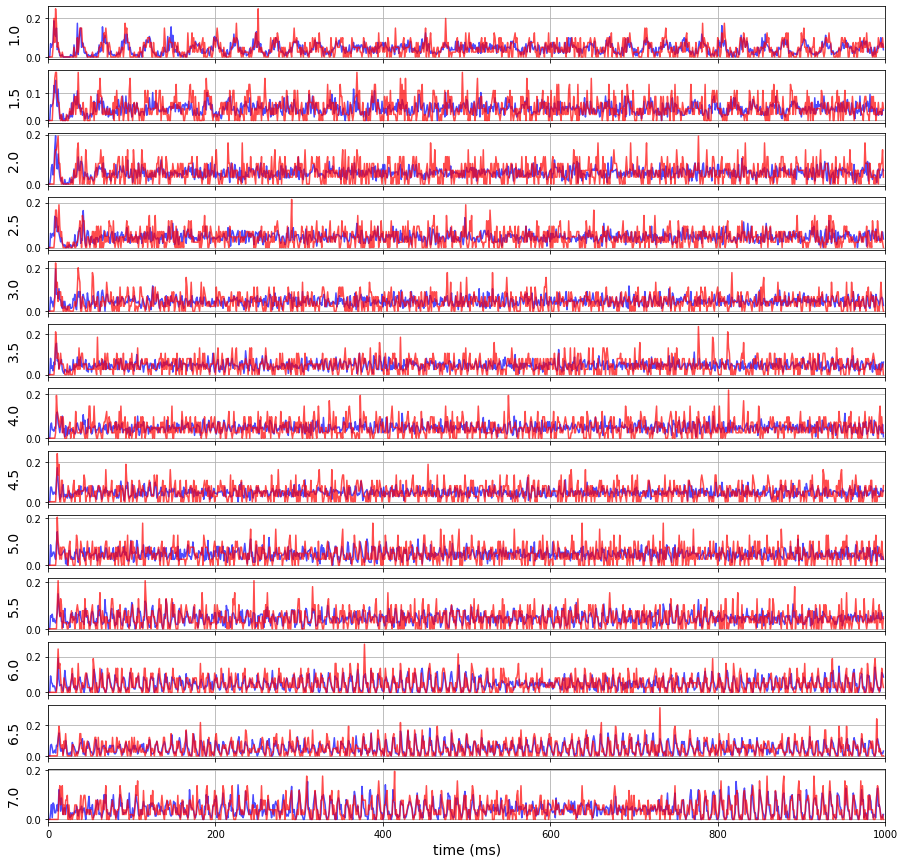

In [69]:
fig, axes = plt.subplots(len(delays),1, figsize = (15,15), sharex = True)

binsize = 1
bins = np.arange(0, sim_length, binsize)
for i, delay in enumerate(delays):
    # calculate the spike rates using histogram
    ex_hist, in_hist, bins = net_spike_rates(nets[i], sim_length, binsize = binsize)

    axes[i].plot(bins[:-1], ex_hist, c = 'blue', alpha = 0.7)
    axes[i].plot(bins[:-1], in_hist, c = 'red', alpha = 0.7)
    axes[i].grid()
    axes[i].set_ylabel(delay, fontsize = 14)
axes[-1].set_xlim(0, sim_length)
axes[-1].set_xlabel('time (ms)', fontsize = 14)
plt.show()

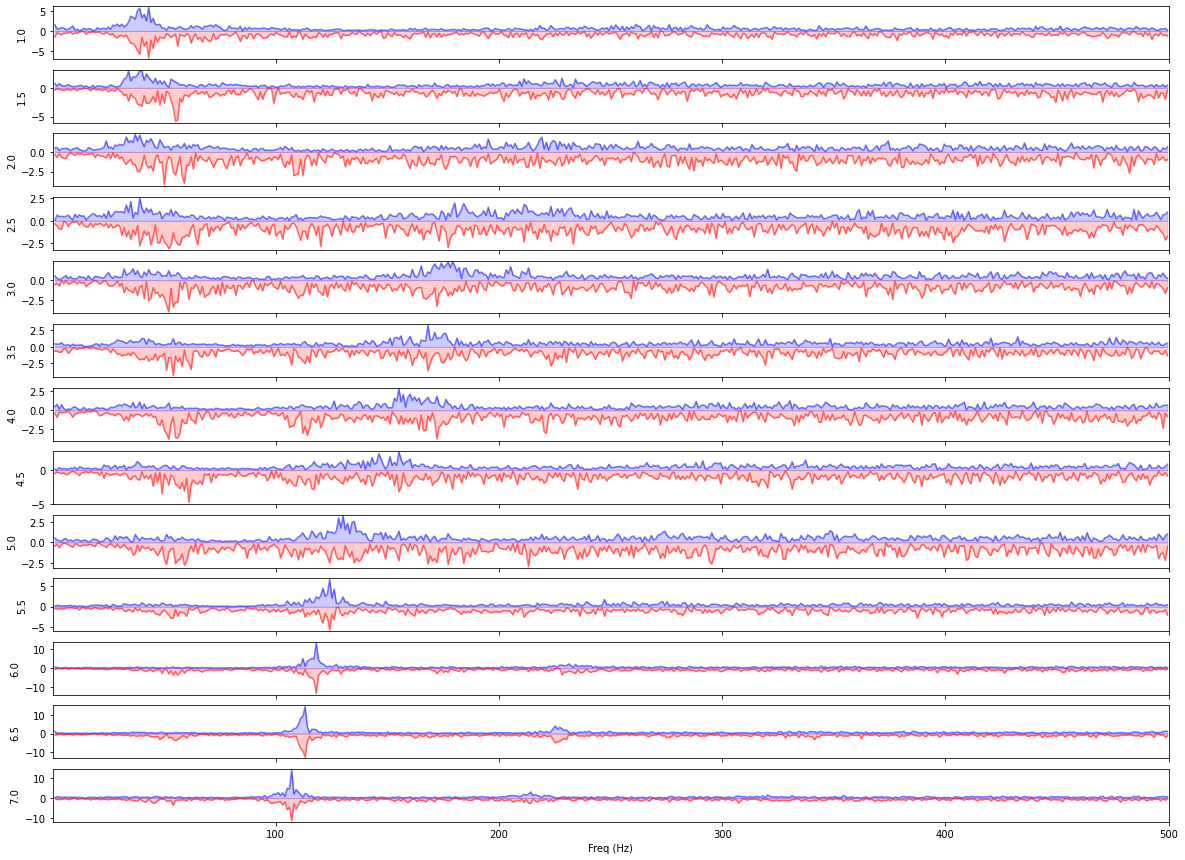

In [71]:
fig, axes = plt.subplots(len(delays),1, figsize = (20,15), sharex = True)
dt = 1
min_freq = 0.01
for i, delay in enumerate(delays):
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(nets[i], sim_length, dt = 1, min_freq = 0.01)
    axes[i].fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    axes[i].fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    axes[i].plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    axes[i].plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    #axes[i].set_yscale('log')
    
    axes[i].set_ylabel(delay)
    #axes[i].set_ylim(0, 1.05*np.max(np.abs(yf_ex)))
    axes[i].set_ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    
axes[-1].set_xlim(min_freq, sim_length/2)
axes[-1].set_xlabel('Freq (Hz)')
plt.show()

### number of cells

In [35]:
delay = 2.5

ex_ratio = .8
n_cells_spread = np.arange(100, 1101, 200)

print('initiating nets')
nets = [Net(n_cells, ex_ratio) for n_cells in n_cells_spread]

print('connecting nets')
for i, n_cells in enumerate(n_cells_spread):    
    # set up simulation
    nets[i].randomly_connect_cells(weight = .2, delay = delay, delay_scaling=False)
    nets[i].initial_stimulation(100, 1)

print('running simulations simultaneously')
# run simulation
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

[_net.aggregate_all_spikes() for _net in nets]
print('done')

initiating nets
connecting nets
running simulations simultaneously
done


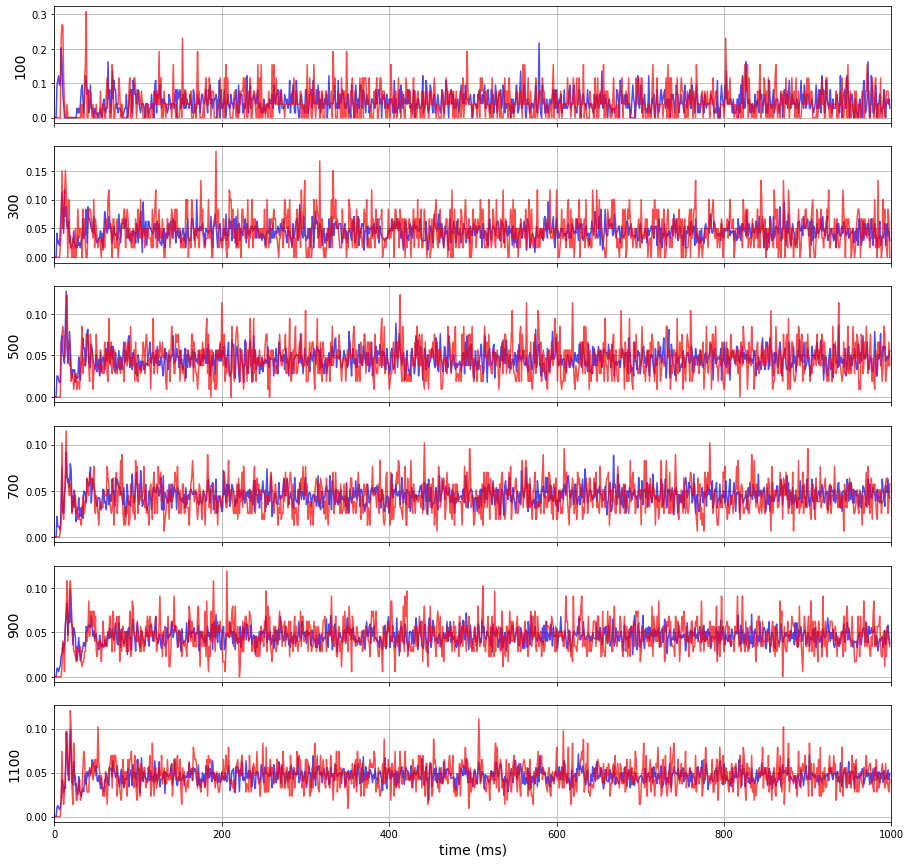

In [38]:
fig, axes = plt.subplots(len(n_cells_spread),1, figsize = (15,15), sharex = True)

binsize = 1
bins = np.arange(0, sim_length, binsize)
for i, n_cells in enumerate(n_cells_spread):
    # calculate the spike rates using histogram
    ex_hist, in_hist, bins = net_spike_rates(nets[i], sim_length, binsize = 1)

    axes[i].plot(bins[:-1], ex_hist, c = 'blue', alpha = 0.7)
    axes[i].plot(bins[:-1], in_hist, c = 'red', alpha = 0.7)
    axes[i].grid()
    axes[i].set_ylabel(n_cells, fontsize = 14)
axes[-1].set_xlim(0, sim_length)
axes[-1].set_xlabel('time (ms)', fontsize = 14)
plt.show()

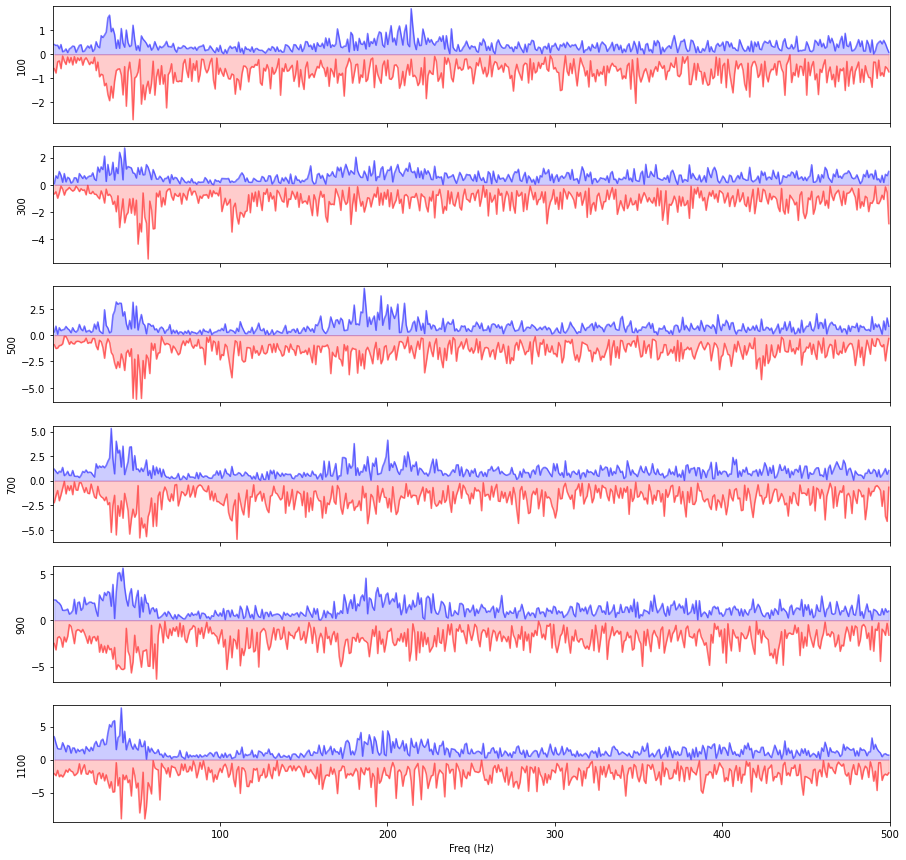

In [39]:
fig, axes = plt.subplots(len(n_cells_spread),1, figsize = (15,15), sharex = True)
dt = 1
min_freq = 0.01
for i, n_cells in enumerate(n_cells_spread):
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(nets[i], sim_length, dt = 1, min_freq = 0.01)
    axes[i].fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    axes[i].fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    axes[i].plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    axes[i].plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    
    axes[i].set_ylabel(n_cells)
    axes[i].set_ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    
axes[-1].set_xlim(min_freq, sim_length/2)
axes[-1].set_xlabel('Freq (Hz)')
plt.show()

### excitatory ratio

In [32]:
delay = 2.5

ex_ratios = np.arange(.3, 1, .1)
n_cells = 200

print('initiating nets')
nets = [Net(n_cells, ex_ratio) for ex_ratio in ex_ratios]

print('connecting nets')
for i, ex_ratio in enumerate(ex_ratios):    
    # set up simulation
    nets[i].randomly_connect_cells(weight = .2, delay = delay, delay_scaling=False)
    nets[i].initial_stimulation(100, 1)

print('running simulations simultaneously')
# run simulation
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

[_net.aggregate_all_spikes() for _net in nets]
print('done')

initiating nets
connecting nets
running simulations simultaneously
done


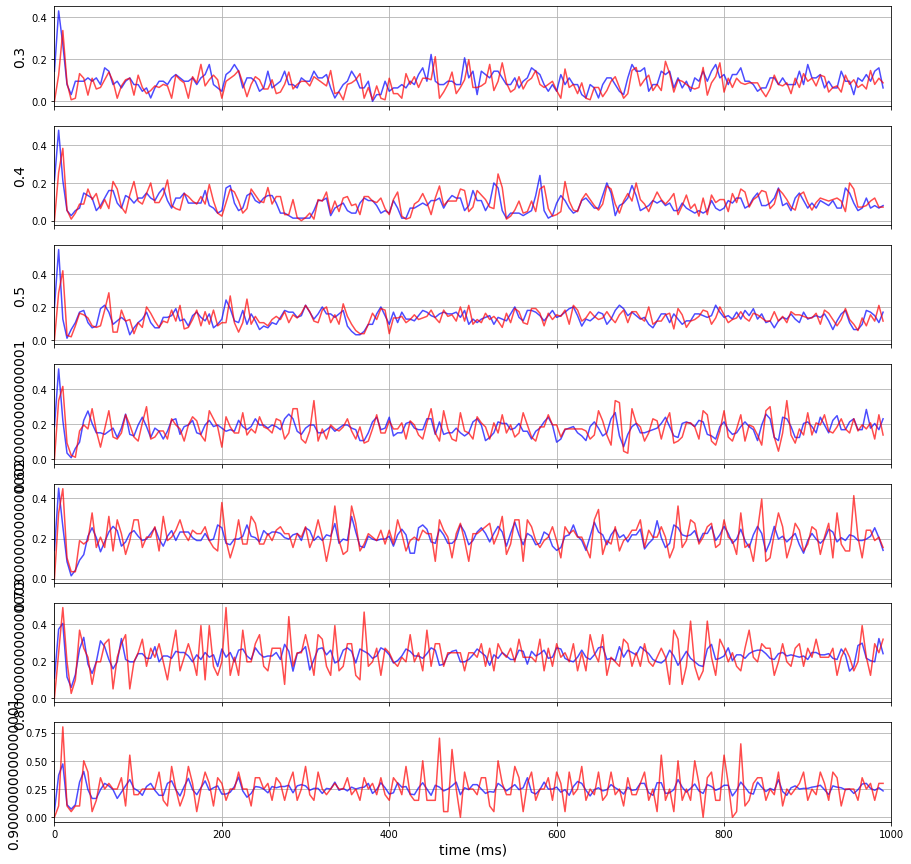

In [33]:
fig, axes = plt.subplots(len(ex_ratios),1, figsize = (15,15), sharex = True)

binsize = 5
bins = np.arange(0, sim_length, binsize)
for i, ex_ratio in enumerate(ex_ratios):
    # calculate the spike rates using histogram
    ex_hist, in_hist, bins = net_spike_rates(nets[i], sim_length, binsize = binsize)

    axes[i].plot(bins[:-1], ex_hist, c = 'blue', alpha = 0.7)
    axes[i].plot(bins[:-1], in_hist, c = 'red', alpha = 0.7)
    axes[i].grid()
    axes[i].set_ylabel((ex_ratio), fontsize = 14)
axes[-1].set_xlim(0, sim_length)
axes[-1].set_xlabel('time (ms)', fontsize = 14)
plt.show()

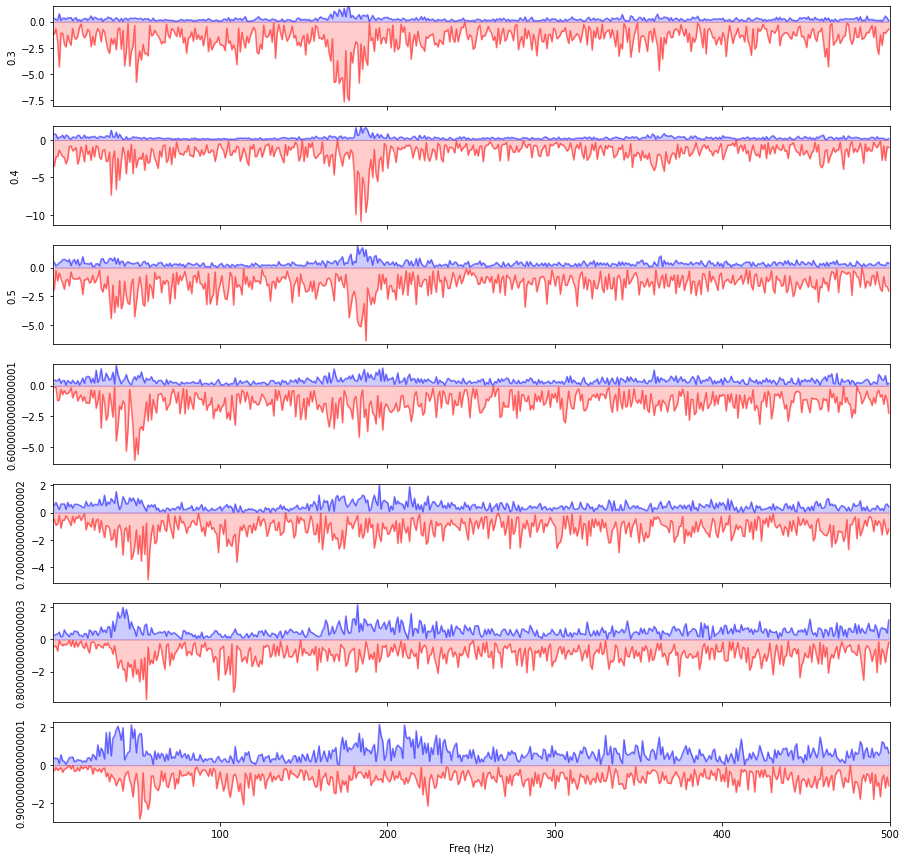

In [34]:
fig, axes = plt.subplots(len(ex_ratios),1, figsize = (15,15), sharex = True)
dt = 1
min_freq = 0.01
for i, ex_ratio in enumerate(ex_ratios):
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(nets[i], sim_length, dt = 1, min_freq = 0.01)
    axes[i].fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    axes[i].fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    axes[i].plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    axes[i].plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    
    axes[i].set_ylabel(ex_ratio)
    axes[i].set_ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    
axes[-1].set_xlim(min_freq, sim_length/2)
axes[-1].set_xlabel('Freq (Hz)')
plt.show()

### weight

In [25]:
delay = 2.5

ex_ratio = .75
n_cells = 200

weights = np.arange(.1,.7,.1)

print('initiating nets')
nets = [Net(n_cells, ex_ratio) for weight in weights]

print('connecting nets')
for i, weight in enumerate(weights):    
    # set up simulation
    nets[i].randomly_connect_cells(weight = weight, delay = delay, delay_scaling=False)
    nets[i].initial_stimulation(100, 1)

print('running simulations simultaneously')
# run simulation
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

[_net.aggregate_all_spikes() for _net in nets]
print('done')

initiating nets
connecting nets
running simulations simultaneously
done


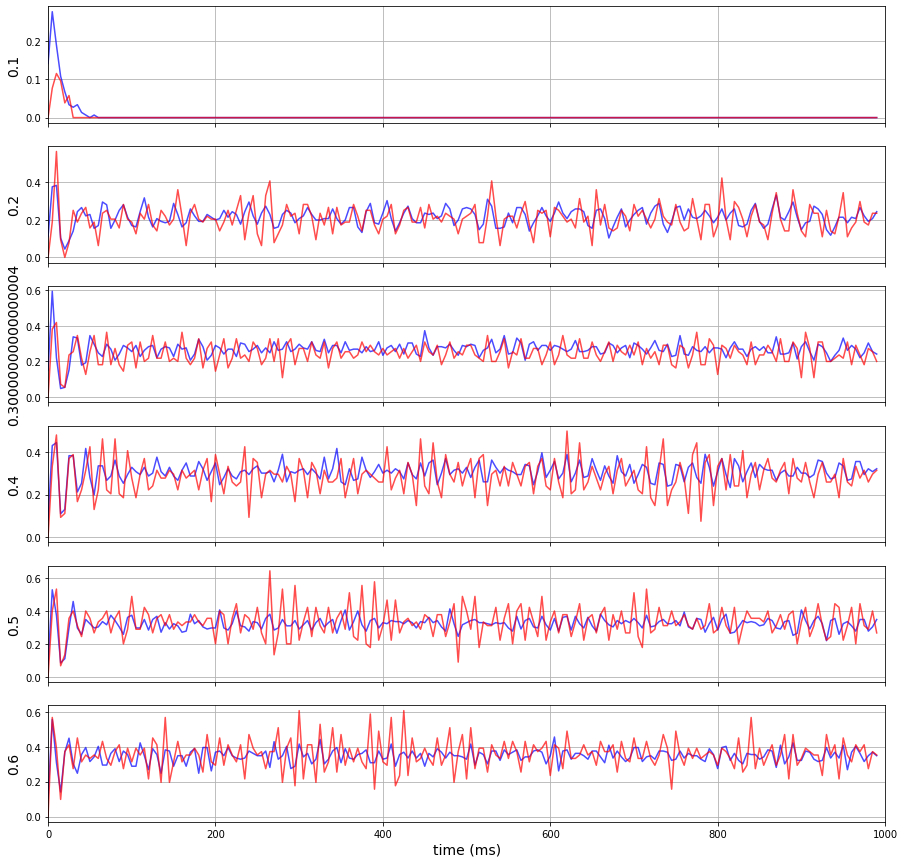

In [30]:
fig, axes = plt.subplots(len(weights),1, figsize = (15,15), sharex = True)

binsize = 5
bins = np.arange(0, sim_length, binsize)
for i, weight in enumerate(weights):
    # calculate the spike rates using histogram
    ex_hist, in_hist, bins = net_spike_rates(nets[i], sim_length, binsize = binsize)

    axes[i].plot(bins[:-1], ex_hist, c = 'blue', alpha = 0.7)
    axes[i].plot(bins[:-1], in_hist, c = 'red', alpha = 0.7)
    axes[i].grid()
    axes[i].set_ylabel(weight, fontsize = 14)
axes[-1].set_xlim(0, sim_length)
axes[-1].set_xlabel('time (ms)', fontsize = 14)
plt.show()

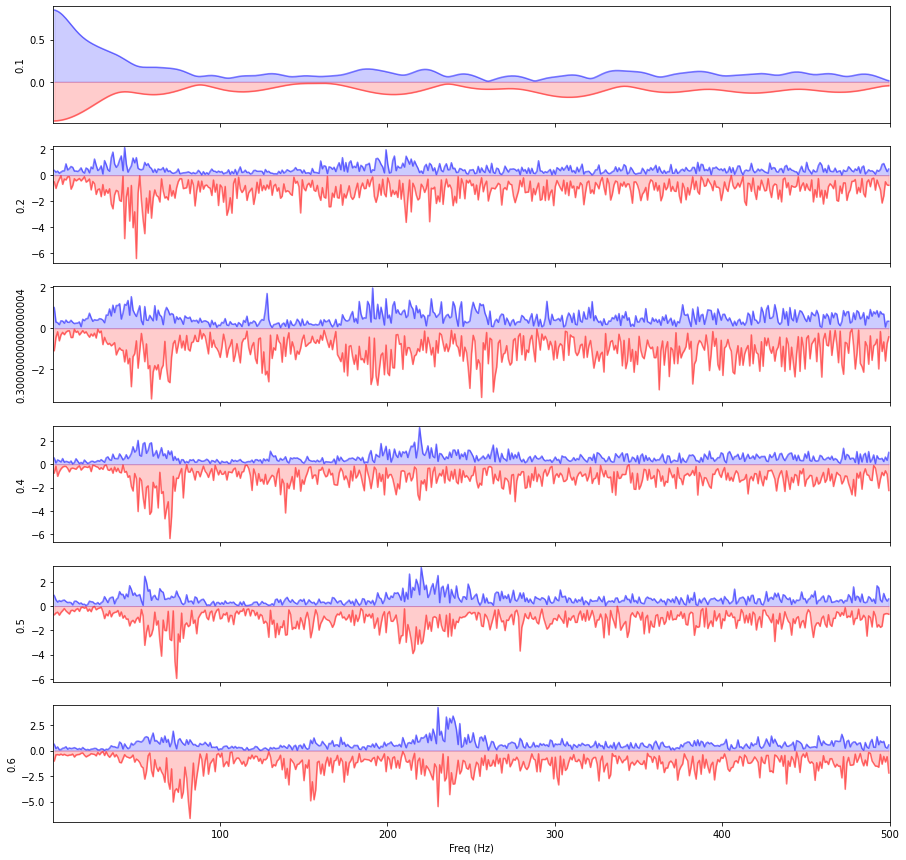

In [28]:
fig, axes = plt.subplots(len(weights),1, figsize = (15,15), sharex = True)
dt = 1
min_freq = 0.01
for i, weight in enumerate(weights):
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(nets[i], sim_length, dt = 1, min_freq = 0.01)
    axes[i].fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    axes[i].fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    axes[i].plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    axes[i].plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    
    axes[i].set_ylabel(weight)
    axes[i].set_ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    
axes[-1].set_xlim(min_freq, sim_length/2)
axes[-1].set_xlabel('Freq (Hz)')
plt.show()

### simulation variation

In [41]:
delay = 2.5

ex_ratio = .8
n_cells = 200

print('initiating nets')
nets = [Net(n_cells, ex_ratio) for i in range(5)]

print('connecting nets')
for i in range(5):    
    # set up simulation
    nets[i].randomly_connect_cells(weight = .2, delay = delay, delay_scaling=False)
    nets[i].initial_stimulation(100, 1)

print('running simulations simultaneously')
# run simulation
sim_length = 1000
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(sim_length)

[_net.aggregate_all_spikes() for _net in nets]
print('done')

initiating nets
connecting nets
running simulations simultaneously
done


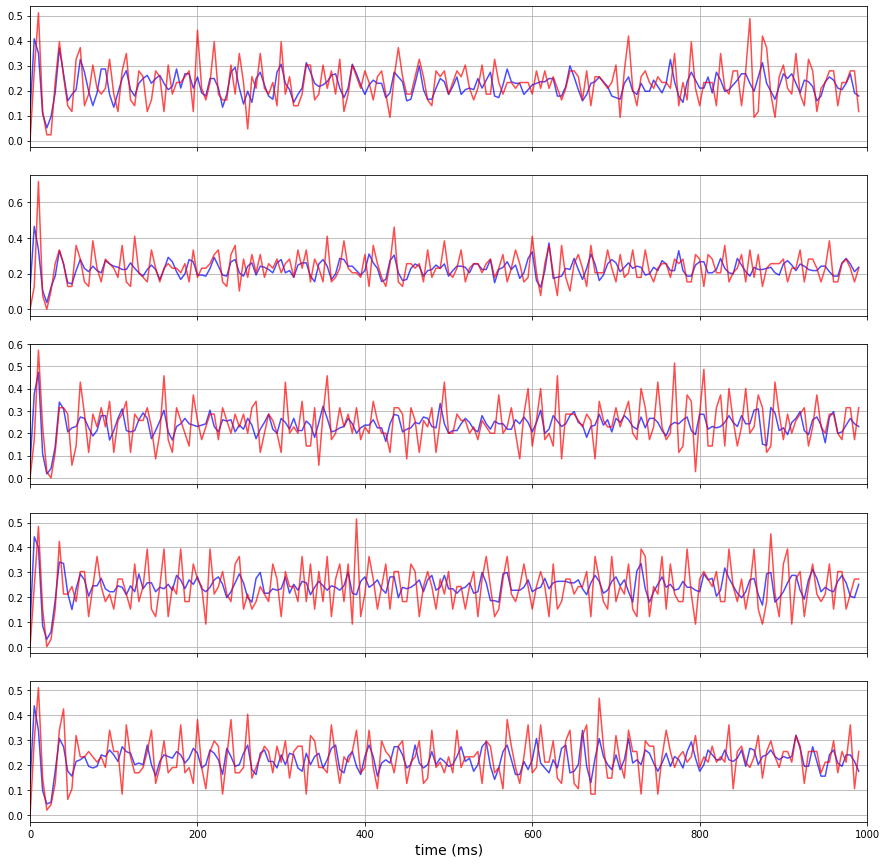

In [44]:
fig, axes = plt.subplots(5,1, figsize = (15,15), sharex = True)

binsize = 5
bins = np.arange(0, sim_length, binsize)
for i in range(5):
    # calculate the spike rates using histogram
    ex_hist, in_hist, bins = net_spike_rates(nets[i], sim_length, binsize = binsize)

    axes[i].plot(bins[:-1], ex_hist, c = 'blue', alpha = 0.7)
    axes[i].plot(bins[:-1], in_hist, c = 'red', alpha = 0.7)
    axes[i].grid()
axes[-1].set_xlim(0, sim_length)
axes[-1].set_xlabel('time (ms)', fontsize = 14)
plt.show()

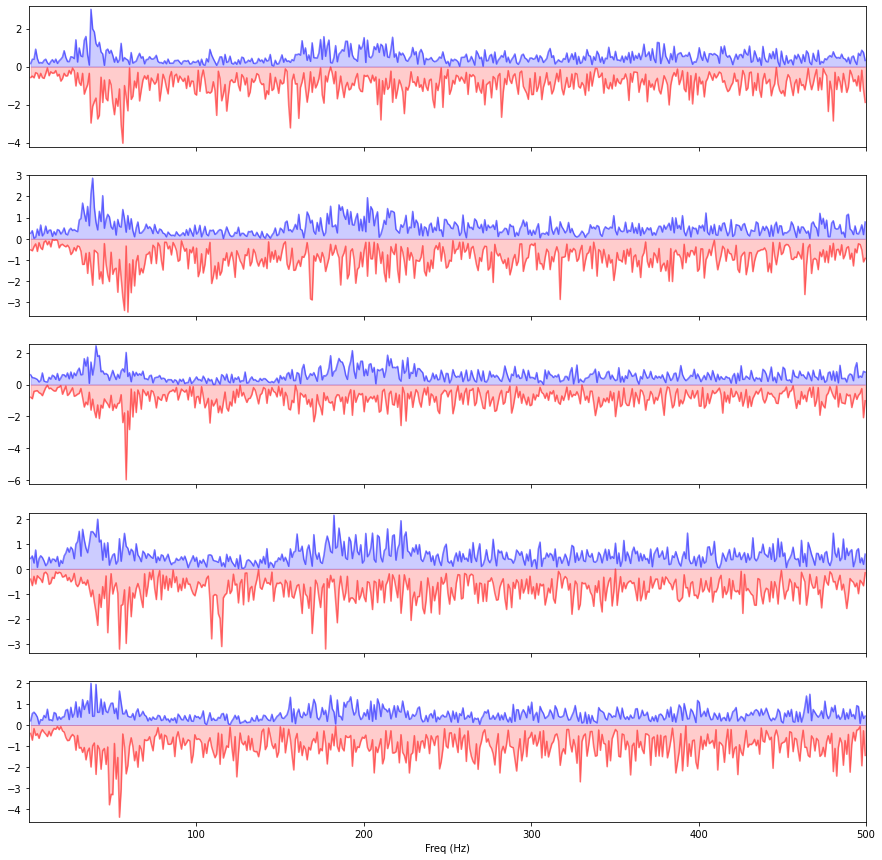

In [45]:
fig, axes = plt.subplots(5,1, figsize = (15,15), sharex = True)
dt = 1
min_freq = 0.01
for i in range(5):
    xf_ex, yf_ex, xf_in, yf_in = net_spike_fft(nets[i], sim_length, dt = 1, min_freq = 0.01)
    axes[i].fill_between(xf_ex.reshape(-1), np.abs(yf_ex).reshape(-1), 0, color='blue', alpha=.2)
    axes[i].fill_between(xf_in.reshape(-1), -np.abs(yf_in).reshape(-1), 0, color='red', alpha=.2)
    
    axes[i].plot(xf_ex, np.abs(yf_ex), c = 'blue', alpha = .5)
    axes[i].plot(xf_in, -np.abs(yf_in), c = 'red', alpha = .5)
    
    axes[i].set_ylim(-1.05*np.max(np.abs(yf_in)), 1.05*np.max(np.abs(yf_ex)))
    
axes[-1].set_xlim(min_freq, sim_length/2)
axes[-1].set_xlabel('Freq (Hz)')
plt.show()